In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import gzip
sys.path.append('../src/')
import helpers as h
%matplotlib inline

In [20]:
def import_msprime_sfs(file_list, n_samples):
    n_files = len(file_list)
    mSFS = np.zeros((n_files, n_samples-1))
    jSFS_triu = np.zeros((n_files, n_samples*(n_samples-1)//2))
    
    # Import data from files
    for i, f in enumerate(file_list):
        with open(f) as datafile:
            for line in datafile:
                # Skip header lines
                if line.startswith('#'):
                    continue
                # First two non-header lines contain the marginal and joint SFS
                mSFS[i,:] = np.array(line.split(), dtype=float)
                jSFS_triu[i,:] = np.array(datafile.readline().split())
                break
                
    # Unpack the joint SFS
    jSFS = np.zeros((n_files, n_samples-1, n_samples-1))
    for i in range(n_files):
        jSFS[i,:,:][np.triu_indices(n_samples-1)] = jSFS_triu[i,:]
        # Don't double-count the diagonal values
        jSFS[i,:,:][np.diag_indices(n_samples-1)] /= 2
    # Symmetrize distribution
    jSFS += np.transpose(jSFS, axes=(0,2,1))
    
    # Fold marginal and joint SFS.
    mSFS_fold = (mSFS + mSFS[:,::-1])[:,:n_samples//2]
    jSFS_fold = (jSFS + jSFS[:,::-1,:] + jSFS[:,:,::-1] + jSFS[:,::-1,::-1])[:, :n_samples//2, :n_samples//2]
    # Don't double-count the n/2 = n - n/2 values.
    if n_samples % 2 == 0:
        mSFS_fold[:,-1] /= 2
        jSFS_fold[:,-1,:-1] /= 2
        jSFS_fold[:,:-1,-1] /= 2
        jSFS_fold[:,-1,-1] /= 4

    pi = h.sfs2pi(mSFS_fold.T, n_samples)

    return pi, mSFS_fold, jSFS_fold

In [2]:
n_samples = 100

Import SLiM output

In [73]:
fn_slim = '../simulations/slim/sweeps_fsel-0.0_corrmerged.txt.gz'
r_slim = 1e-8
mu_slim = 1e-7
L = int(1e8)
w = int(1e3)
lim = L//(10*w)
dist = w*np.arange(lim + 1)

lohi_corr_slim = np.zeros((n_samples//2 - 1, dist.shape[0]))
with gzip.open(fn_slim, 'rb') as infile:
    # SFS header and SFS
    infile.readline()
    sfs_slim = np.array(infile.readline().split(), dtype=float)
    # PI_CORR header and PI_CORR
    infile.readline()
    pi_corr_slim = np.array(infile.readline().split(), dtype=float)
    # LOHI_CORR header and LOHI_CORR
    infile.readline()
    for j, line in enumerate(infile):
        lohi_corr_slim[j,:] = line.split()
    pi_slim = h.sfs2pi(sfs_slim, n_samples)
    lo_slim = np.cumsum(sfs_slim)[:-1]
    hi_slim = np.sum(sfs_slim) - lo_slim
d_c = (2.0*mu_slim)/(pi_slim*r_slim)

Import msprime output

In [122]:
r_list = np.insert(np.logspace(-1,3,13), 0, 0.0)[:-3]
file_list = ['../simulations/jsfs_a-2.0_r-{}.txt'.format(r) for r in r_list]
pi_mspr, sfs_mspr, jsfs_mspr = import_msprime_sfs(file_list, n_samples)
print(np.sum(sfs_mspr,axis=1), np.sum(jsfs_mspr,axis=(1,2)))
print(jsfs_mspr[0]/(sfs_mspr[0][:,None]*sfs_mspr[0][None:]) - 1)

[ 10.35395282  10.35319482  10.35075289  10.35960405  10.35639108
  10.35923684  10.35292236  10.35545646  10.35336399  10.36067743
  10.3605392 ] [ 113.70971211  112.89291339  112.21476711  111.3305815   109.99463032
  108.91465387  108.0060886   107.6295923   107.33450786  107.41623982
  107.37229643]
[[  1.03078209e-01  -1.01761191e-02  -1.00214298e-02 ...,  -1.31907104e-02
   -1.34832747e-02  -1.01836333e-02]
 [ -1.01761191e-02   3.67109324e-01  -1.79059171e-02 ...,  -3.05061259e-02
   -3.02995211e-02  -4.52591585e-02]
 [ -1.00214298e-02  -1.79059171e-02   7.55153596e-01 ...,  -1.58312948e-02
   -5.27763484e-02  -2.72818490e-02]
 ..., 
 [ -1.31907104e-02  -3.05061259e-02  -1.58312948e-02 ...,   3.35968797e+01
   -5.33510487e-01  -5.26600392e-01]
 [ -1.34832747e-02  -3.02995211e-02  -5.27763484e-02 ...,  -5.33510487e-01
    3.40993944e+01  -5.52055738e-01]
 [ -1.01836333e-02  -4.52591585e-02  -2.72818490e-02 ...,  -5.26600392e-01
   -5.52055738e-01   7.15575395e+01]]


In [158]:
#lohi_corr_slim = np.zeros((n_samples//2 - 1, len(r_list)))
pi_corr_mspr = np.zeros(len(r_list))
pi_weights = h.pairwise_diversity(np.arange(1, n_samples//2+1), n_samples)

lolo_corr_mspr = np.zeros((n_samples//2 - 1, len(r_list)))
lohi_corr_mspr = np.zeros((n_samples//2 - 1, len(r_list)))
hihi_corr_mspr = np.zeros((n_samples//2 - 1, len(r_list)))
for i in range(len(r_list)):
    jsfs = jsfs_mspr[i]
    msfs = sfs_mspr[i]

    pi = pi_mspr[i]
    pi_sq = np.sum(jsfs * pi_weights[:,None] * pi_weights[None,:])
    pi_corr_mspr[i] = pi_sq - pi**2
    
    for cutoff in np.arange(1, n_samples//2):
        j = cutoff - 1
        lo = np.sum(msfs[:cutoff])
        hi = np.sum(msfs[cutoff:])
        lolo = np.sum(jsfs[:cutoff, :cutoff])
        lohi = np.sum(jsfs[:cutoff, cutoff:])
        hihi = np.sum(jsfs[cutoff:, cutoff:])
        #print(np.sum(msfs), lo, hi, lolo, lohi, hihi, lolo+2*lohi+hihi)
        #print(lohi/(lo*hi))
        lolo_corr_mspr[j,i] = lolo / (lo*lo) - 1
        lohi_corr_mspr[j,i] = lohi / (lo*hi) - 1
        hihi_corr_mspr[j,i] = hihi / (hi*hi) - 1

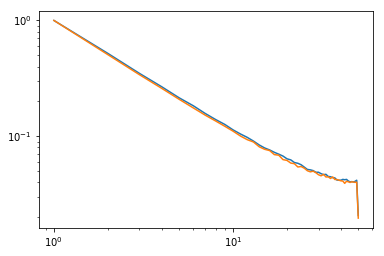

In [159]:
plt.loglog(np.arange(1,n_samples//2+1), sfs_slim/sfs_slim[0])
plt.loglog(np.arange(1,n_samples//2+1), sfs_mspr[0]/sfs_mspr[0,0])

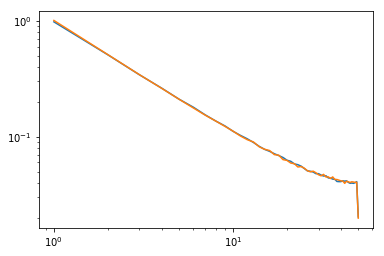

In [160]:
plt.loglog(np.arange(1,n_samples//2+1), sfs_slim/pi_slim)
plt.loglog(np.arange(1,n_samples//2+1), sfs_mspr[0]/pi_mspr[0])

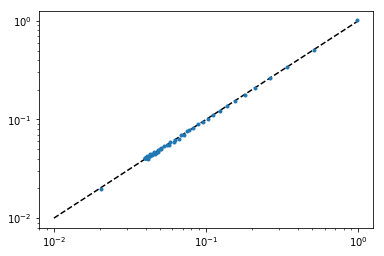

In [161]:
plt.loglog([0.01,1.0],[0.01,1.0], '--k')
plt.loglog(sfs_slim/pi_slim, sfs_mspr[0]/pi_mspr[0], '.')

(-0.01, 0.21)

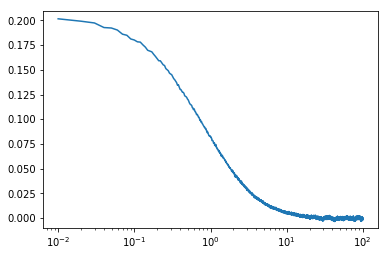

In [162]:
plt.semilogx(dist/d_c, pi_corr_slim/pi_slim**2)
plt.ylim([-0.01,0.21])

(-0.01, 0.21)

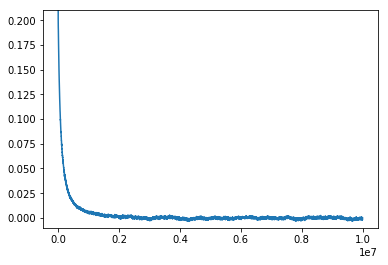

In [163]:
plt.plot(dist, pi_corr_slim/pi_slim**2)
plt.ylim([-0.01,0.21])

(0.001, 0.3)

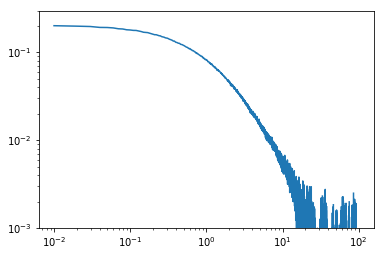

In [164]:
plt.loglog(dist/d_c, pi_corr_slim/pi_slim**2)
plt.ylim([1e-3,0.3])

(-1, 21)

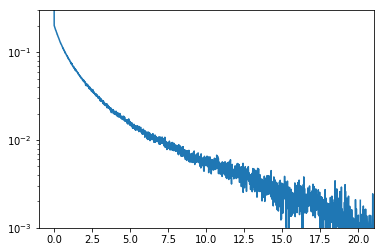

In [165]:
plt.semilogy(dist/d_c, pi_corr_slim/pi_slim**2)
plt.ylim([1e-3,0.3])
plt.xlim([-1,21])

(-0.01, 1.01)

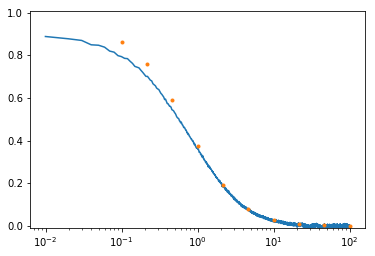

In [180]:
plt.semilogx(dist/d_c, (pi_corr_slim*2.0**2)/(pi_slim**2*pi_corr_mspr[0]))
plt.semilogx(r_list*pi_mspr/2, pi_corr_mspr/pi_corr_mspr[0], '.')
plt.ylim([-0.01,1.01])
#plt.ylim([-0.01,0.26])
#plt.hlines(pi_corr_mspr[0]/pi_mspr**2, 0.01, 100)


#plt.ylim([-0.1,1.1])

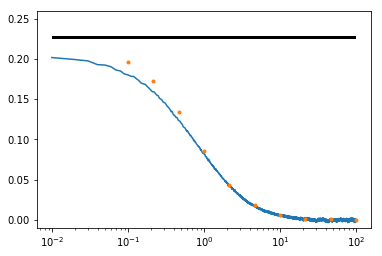

In [212]:
plt.semilogx(dist/d_c, pi_corr_slim/pi_slim**2)
plt.semilogx(r_list, pi_corr_mspr/4, '.')
plt.ylim([-0.01,0.26])
plt.hlines(pi_corr_mspr[0]/pi_mspr**2, 0.01, 100)


#plt.ylim([-0.1,1.1])

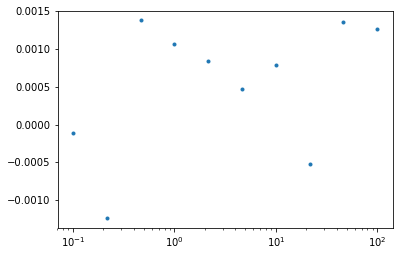

In [218]:
plt.semilogx(r_list, np.log(pi_mspr/2), '.')

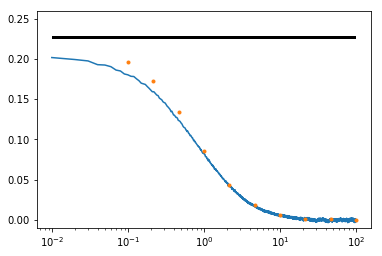

In [208]:
plt.semilogx(dist/d_c, pi_corr_slim/pi_slim**2)
plt.semilogx(r_list*pi_mspr/2, pi_corr_mspr/pi_mspr**2, '.')
plt.ylim([-0.01,0.26])
plt.hlines(pi_corr_mspr[0]/pi_mspr**2, 0.01, 100)


#plt.ylim([-0.1,1.1])

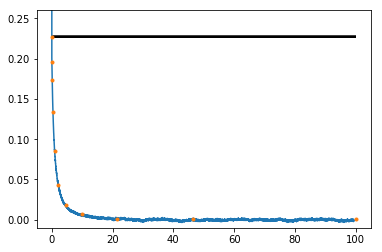

In [209]:
plt.plot(dist/d_c, pi_corr_slim/pi_slim**2)
plt.plot(r_list*pi_mspr/2, pi_corr_mspr/pi_mspr**2, '.')
plt.ylim([-0.01,0.26])
plt.hlines(pi_corr_mspr[0]/pi_mspr**2, 0.01, 100)


#plt.ylim([-0.1,1.1])

In [201]:
print(pi_corr_mspr/4)

[ 0.22699856  0.19551074  0.17248461  0.1341002   0.08517395  0.04329303
  0.01817844  0.00673656  0.00150183  0.00073924  0.00033557]


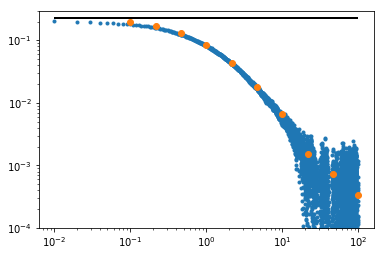

In [167]:
plt.loglog(dist/d_c, pi_corr_slim/pi_slim**2, '.')
plt.loglog(r_list*pi_mspr/2, pi_corr_mspr/pi_mspr**2, 'o')
plt.ylim([1e-4,0.3])
plt.hlines(pi_corr_mspr[0]/pi_mspr**2, 0.01, 100)


#plt.ylim([-0.1,1.1])

(0, 20)

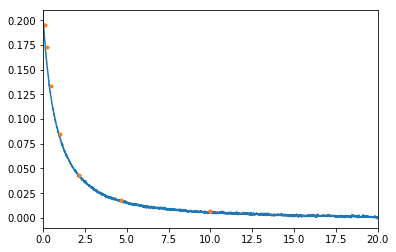

In [168]:
plt.plot(dist/d_c, pi_corr_slim/pi_slim**2)
plt.plot(r_list*pi_mspr/2, pi_corr_mspr/pi_mspr**2, '.')
plt.ylim([-0.01,0.21])
plt.xlim([0,20])
#plt.ylim([-0.1,1.1])

(-0.1, 2.1)

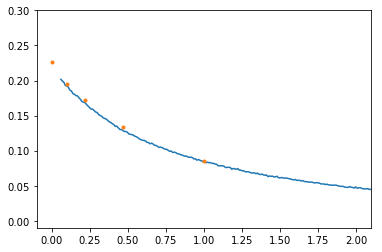

In [199]:
plt.plot((dist[1:]+5*w)/d_c, pi_corr_slim[1:]/pi_slim**2)
plt.plot(r_list*pi_mspr/2, pi_corr_mspr/pi_mspr**2, '.')
plt.ylim([-0.01,0.3])
plt.xlim([-0.1,2.1])
#plt.ylim([-0.1,1.1])

In [170]:
print(pi_corr_slim[1]/pi_slim**2)
print(pi_corr_mspr[0]/pi_mspr[0]**2)

0.201648924783
0.227034641774


In [171]:
print(pi_slim)
print(pi_corr_slim[1])

0.000198679333495
7.95978430701e-09


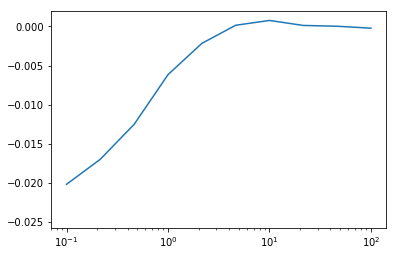

In [172]:
plt.semilogx(r_list*pi_mspr/2, lohi_corr_mspr[5], '-')

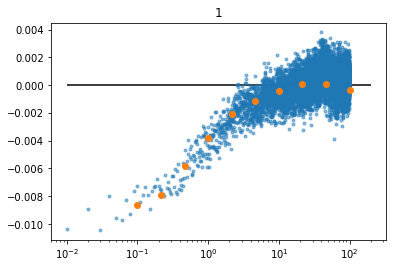

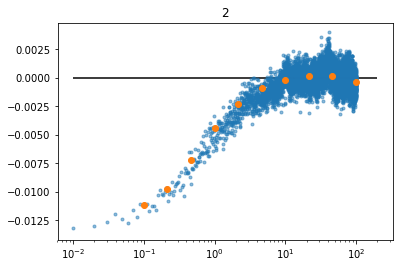

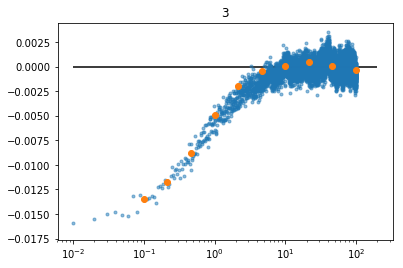

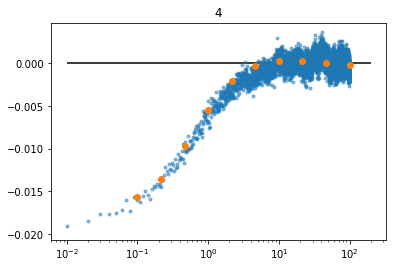

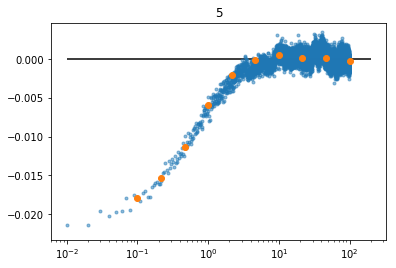

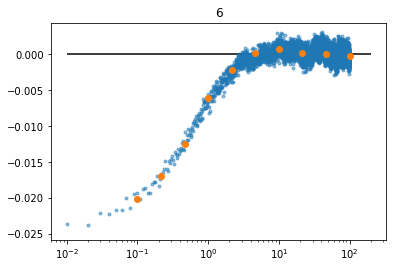

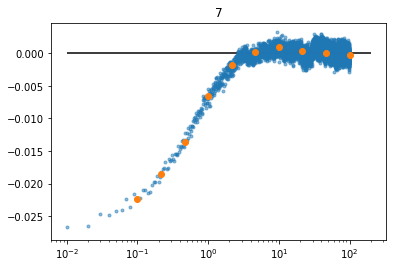

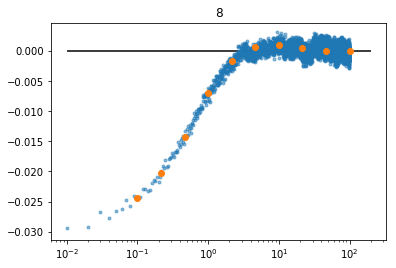

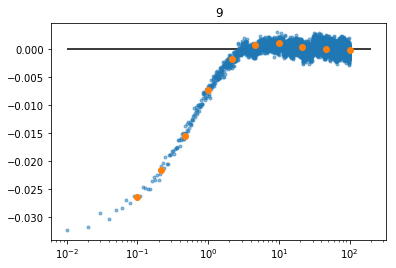

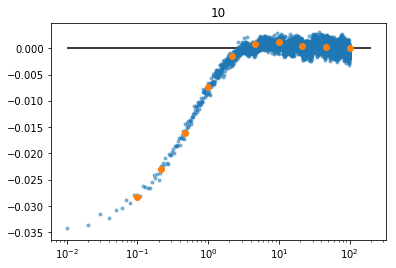

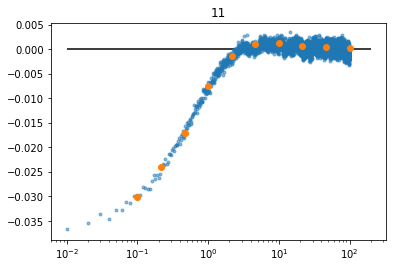

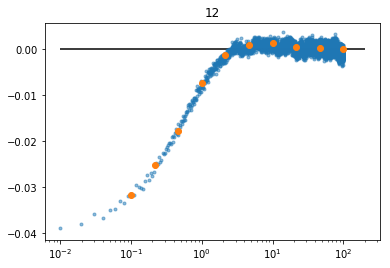

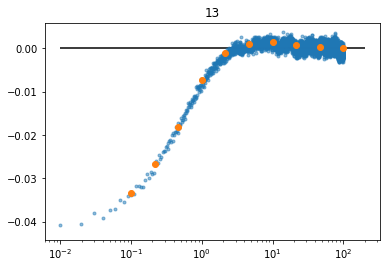

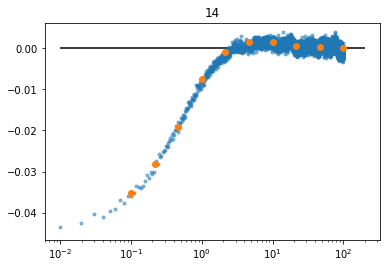

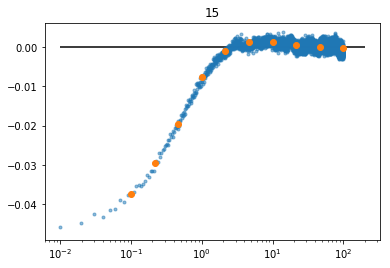

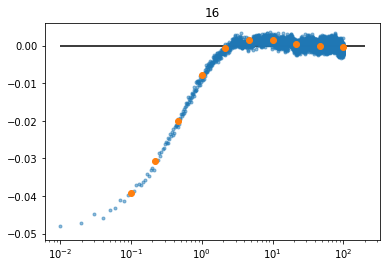

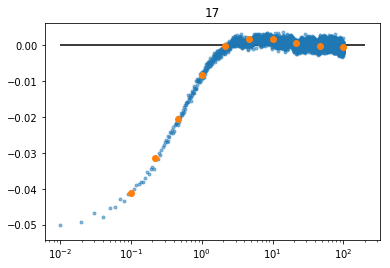

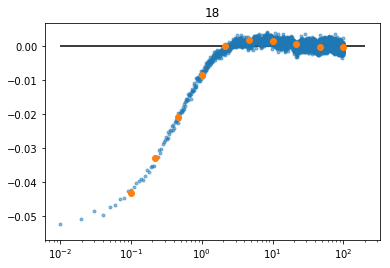

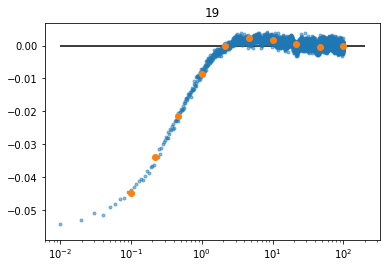

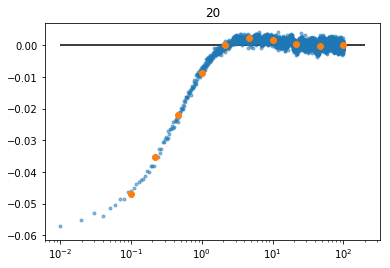

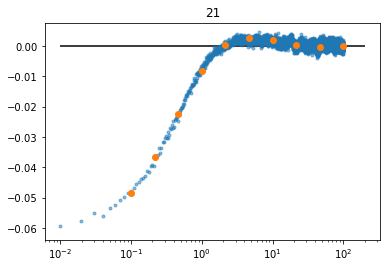

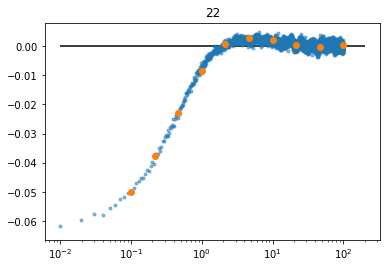

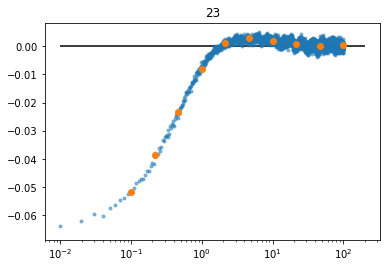

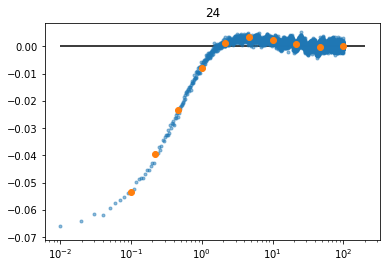

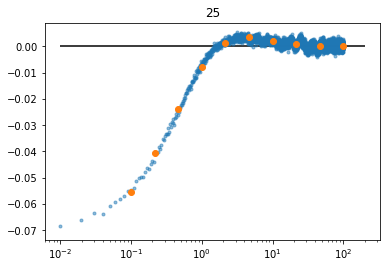

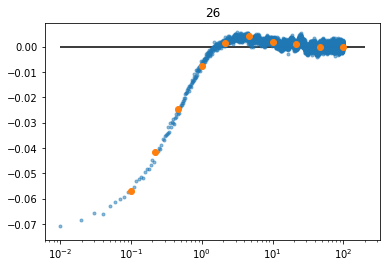

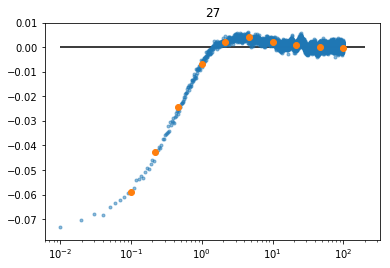

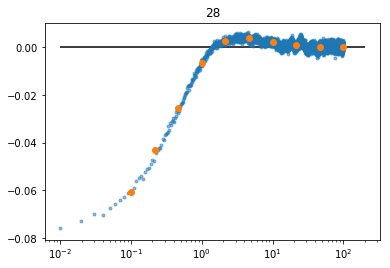

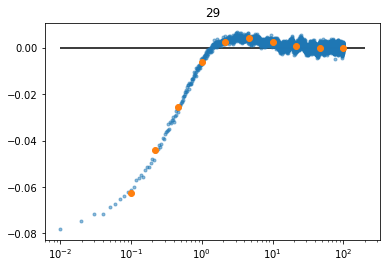

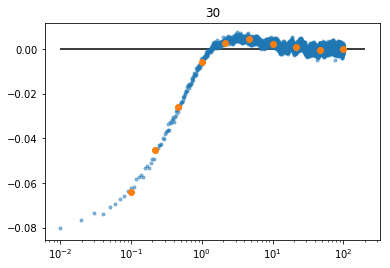

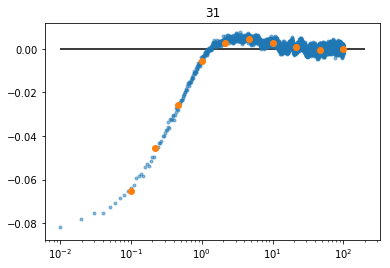

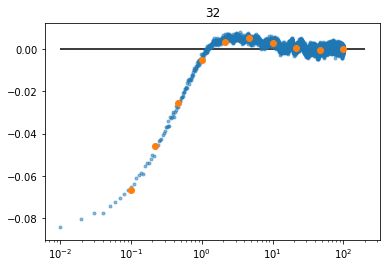

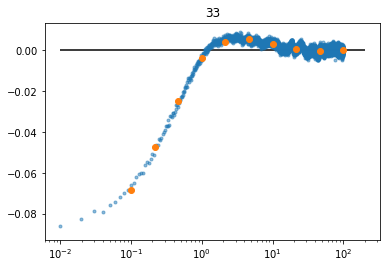

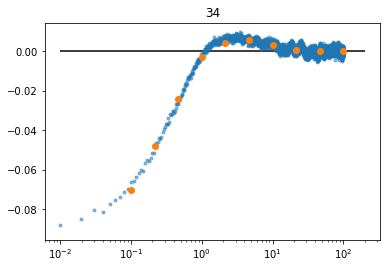

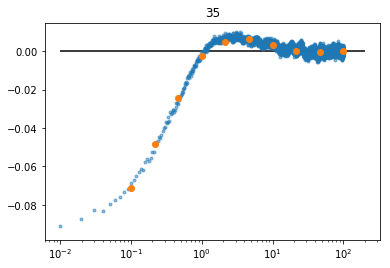

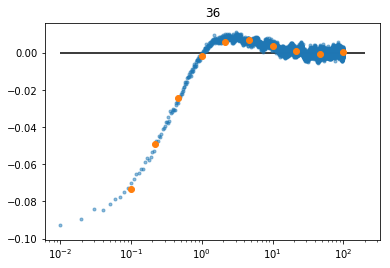

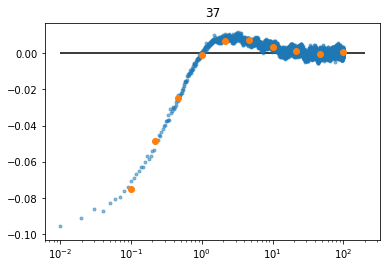

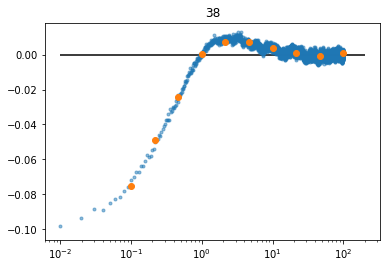

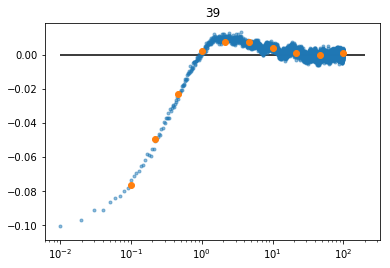

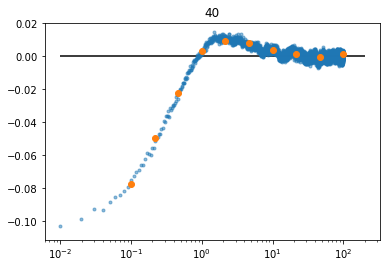

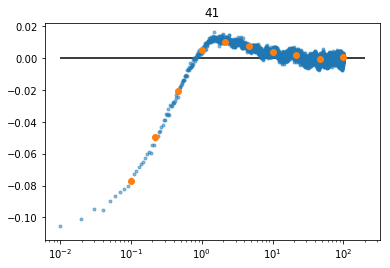

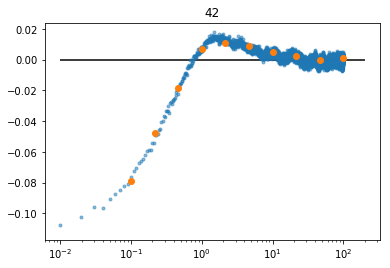

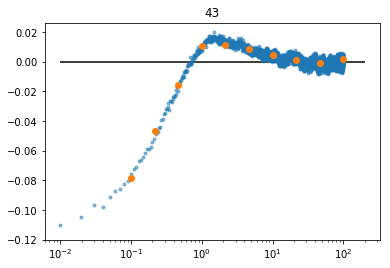

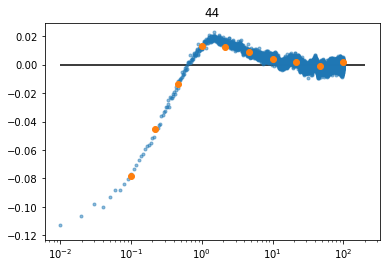

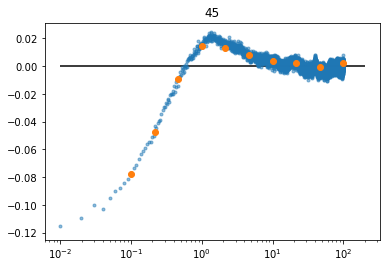

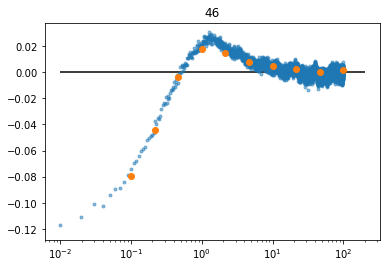

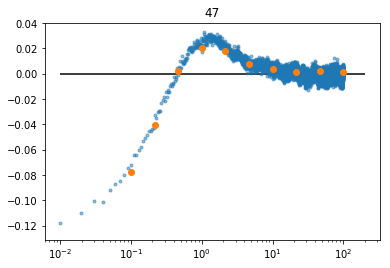

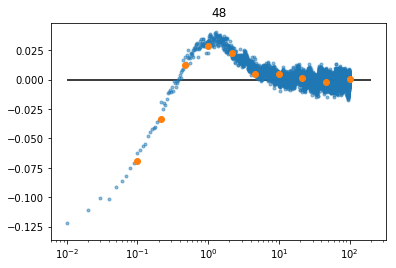

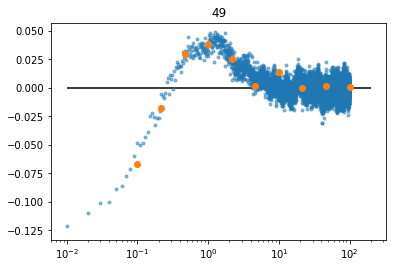

In [173]:
for cutoff in range(1,n_samples//2):
    i = cutoff - 1
    plt.semilogx(dist/d_c, lohi_corr_slim[i]/(lo_slim[i]*hi_slim[i]), '.', alpha=0.5)
    plt.semilogx(r_list*pi_mspr/2, lohi_corr_mspr[i], 'o')
    plt.hlines(0, 1e-2, 2e2)
    plt.title(cutoff)
    plt.show()

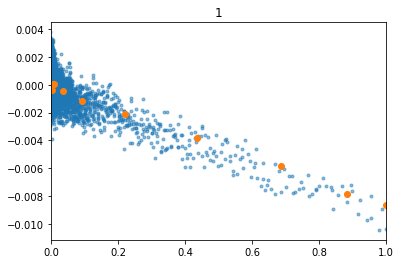

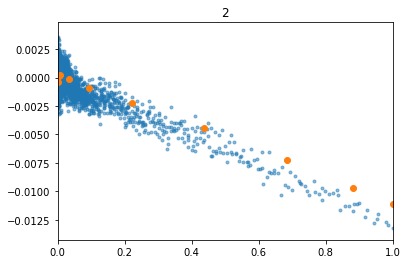

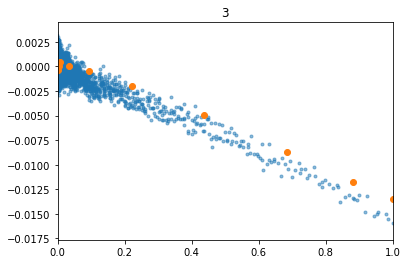

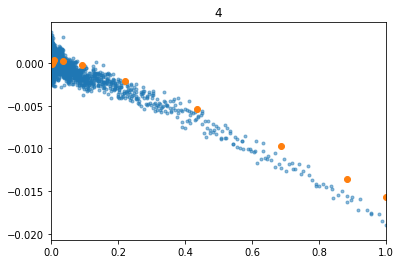

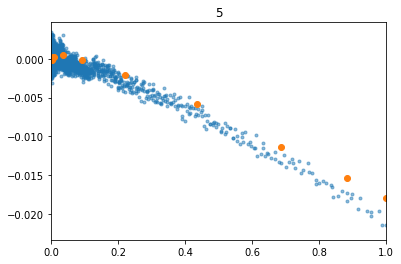

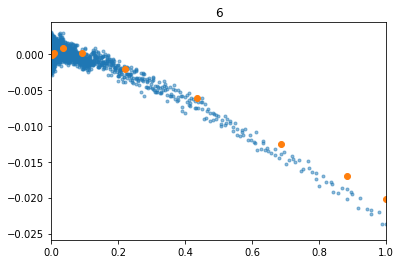

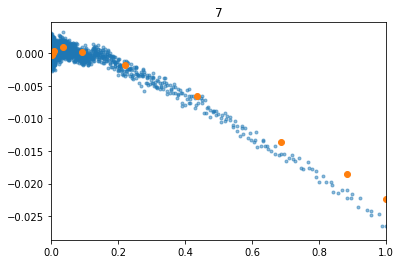

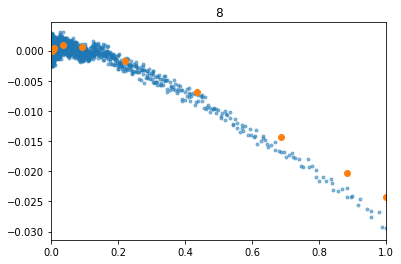

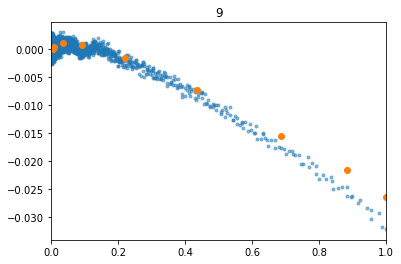

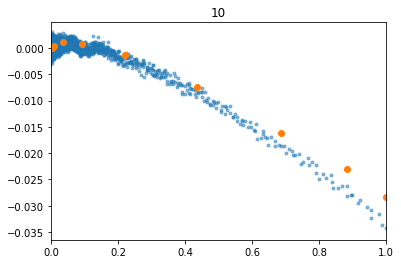

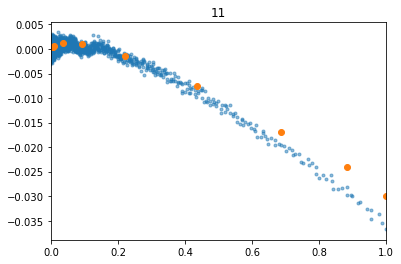

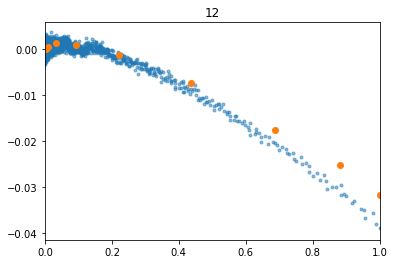

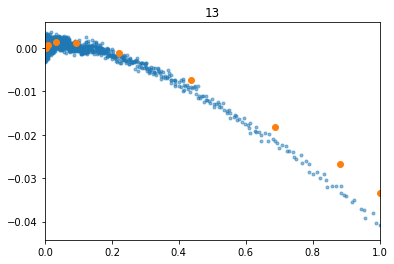

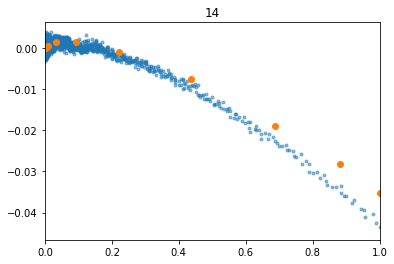

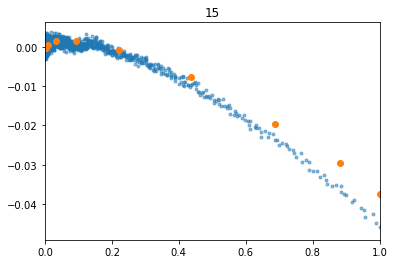

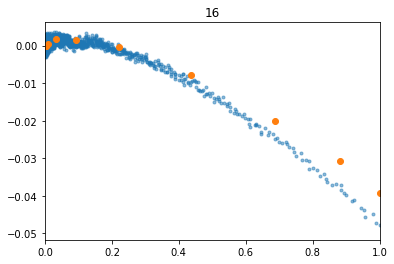

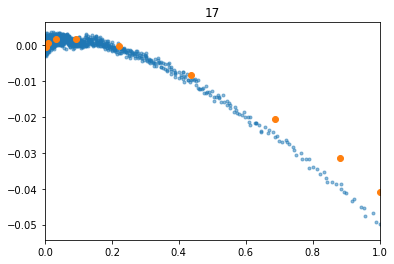

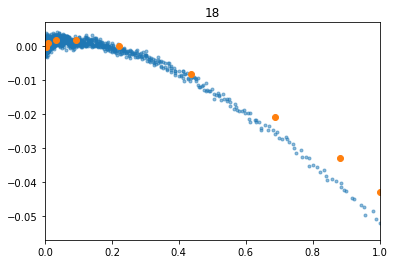

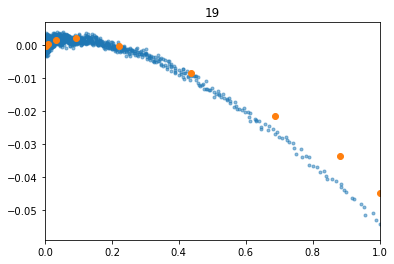

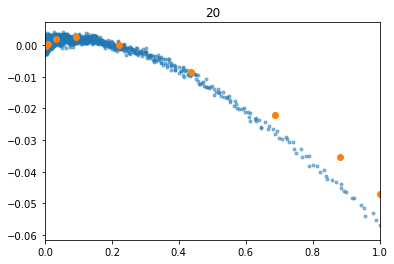

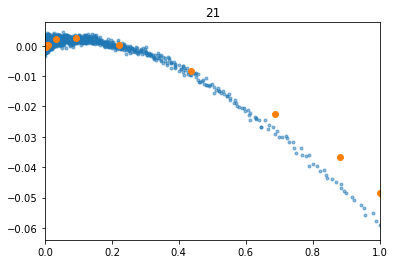

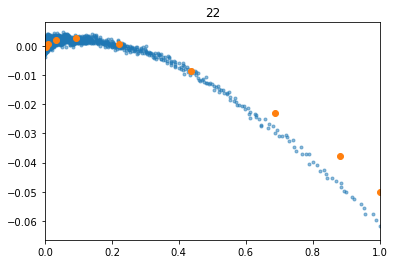

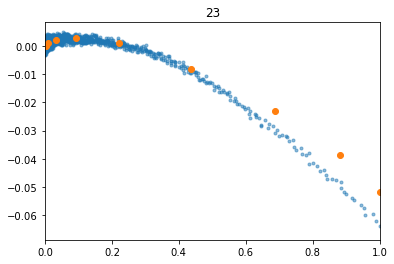

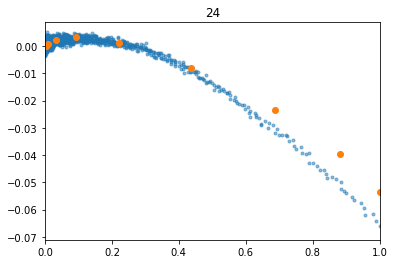

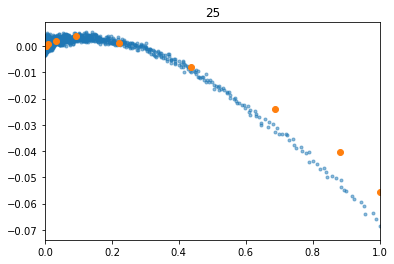

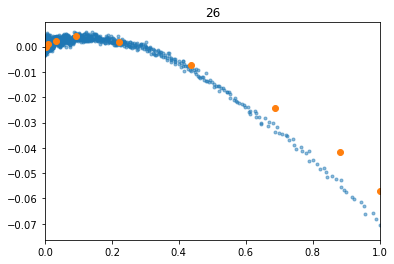

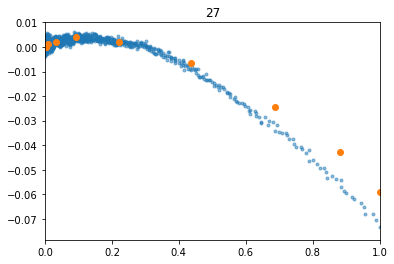

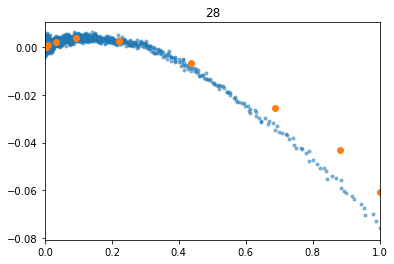

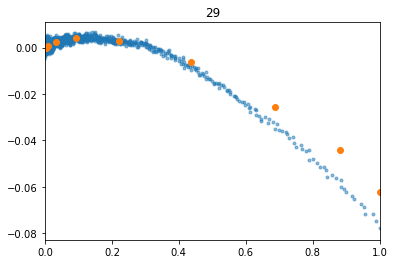

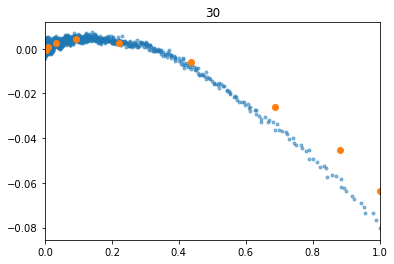

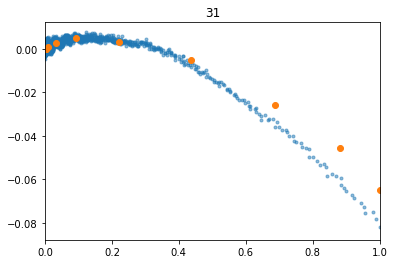

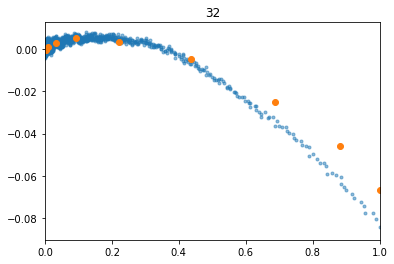

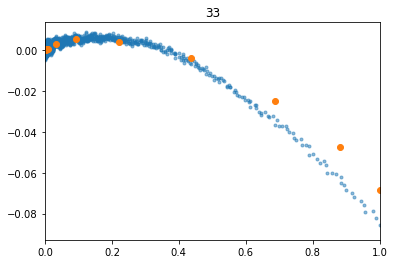

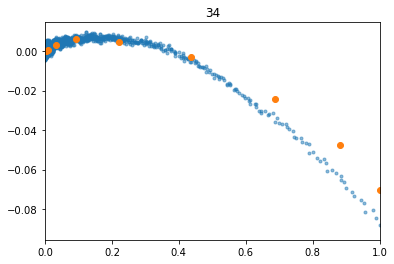

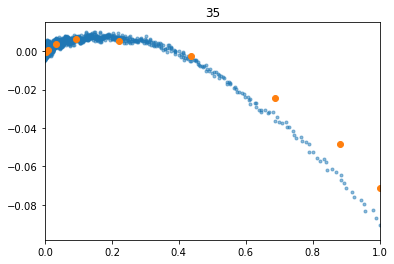

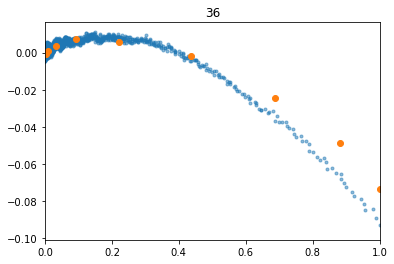

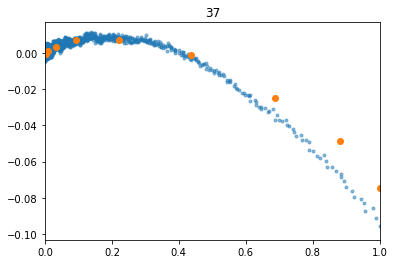

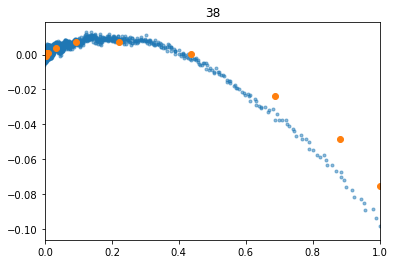

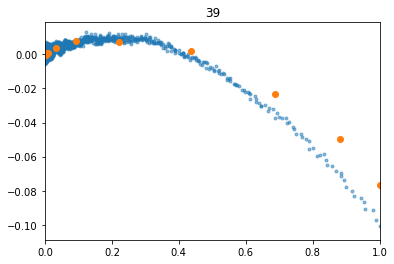

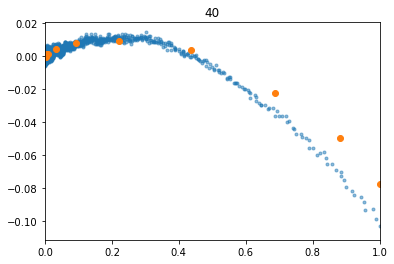

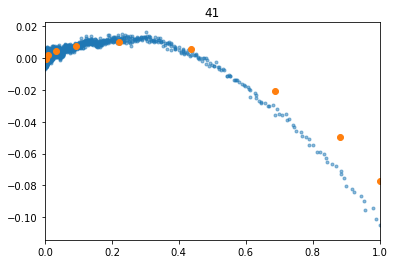

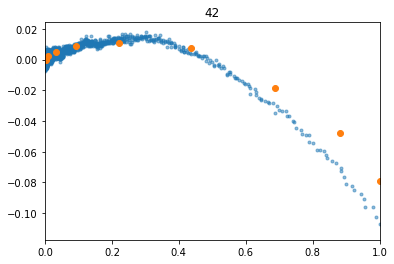

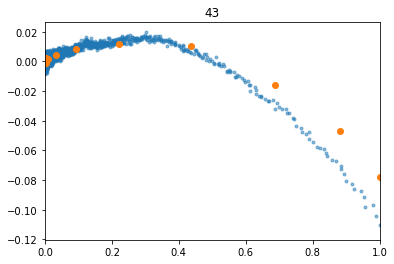

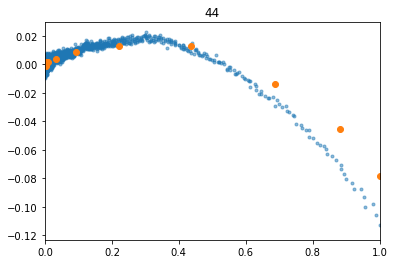

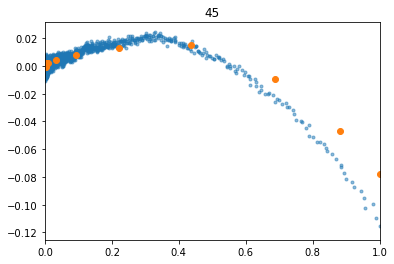

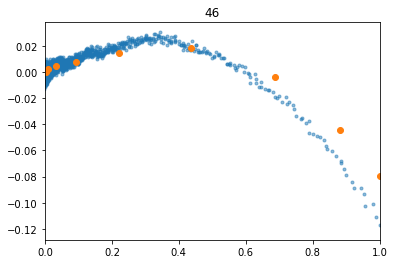

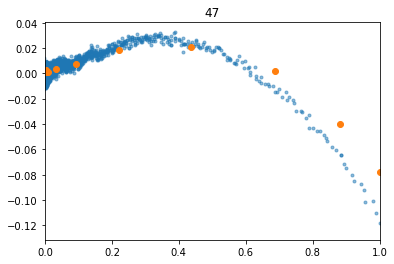

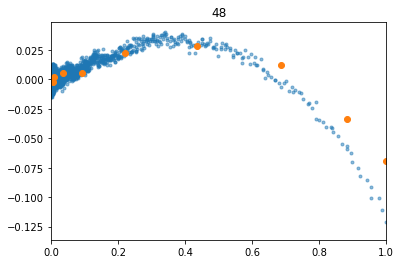

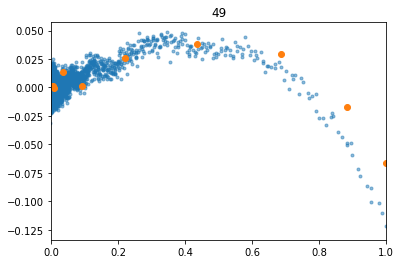

In [194]:
for cutoff in range(1,n_samples//2):
    i = cutoff - 1
    plt.plot(pi_corr_slim/pi_corr_slim[1], lohi_corr_slim[i]/(lo_slim[i]*hi_slim[i]), '.', alpha=0.5)
    plt.plot(pi_corr_mspr/pi_corr_mspr[1], lohi_corr_mspr[i], 'o')
    #plt.hlines(0, 1e-2, 2e2)
    plt.title(cutoff)
    plt.xlim([0,1])
    plt.show()

In [151]:
print(pi_slim)

0.000198679333495


In [157]:
print(pi_corr_mspr)
print(pi_mspr)

[ 384.59058215  379.99169041  376.23631346  371.56951315  364.21899369
  357.88052287  353.43791556  351.61113044  349.99659422  350.68459315
  350.55495094]
[ 1.99984105  1.99976596  1.9975245   2.00275723  2.00212653  2.0016864
  2.00095063  2.00158607  1.99895572  2.00272737  2.00252323]


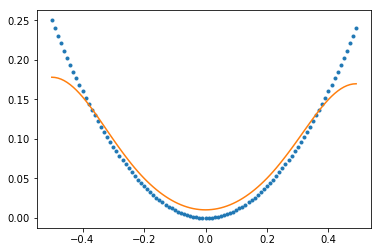

In [190]:
x = np.arange(0,1,0.01) - 0.5
y = x**2
z = h.smooth(y,51,'hamming')
plt.plot(x,y,'.')
plt.plot(x,z,'-')